# 1. 인공지능과 가위바위보 하기

## 미니 프로젝트 : 가위바위보 분류기를 만들자

### 데이터 불러오기 + Resize 하기

In [83]:
# 라이브러리 불러오기
from PIL import Image
import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [84]:
# 이미지 resize
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "rock_scissor_paper/scissor"
resize_images(image_dir_path)

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "rock_scissor_paper/rock"
resize_images(image_dir_path)

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "rock_scissor_paper/paper"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [85]:
# 라벨링
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

데이터의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


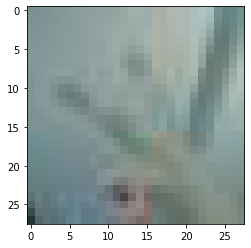

In [86]:
# 참고. 이미지 불러와서 확인
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 설계하기

In [87]:
# tf.keras의 Sequential API를 이용하여 LeNet이라는 딥러닝 네트워크를 설계
n_channel_1=32
n_channel_2=64
n_dense=64

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))  # 독립 변수 컬럼 2352
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))  # 히든 레이어

model.add(keras.layers.Dense(3, activation='softmax'))  # 종속 변수 컬럼 3

print('Model에 추가된 Layer 개수: ', len(model.layers))

# 만든 딥러닝 네트워크 모델 확인
model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 1600)              0         
                                                                 
 dense_45 (Dense)            

### 딥러닝 네트워크 학습시키기

In [88]:
x_train_reshaped=x_train_norm.reshape(-1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 학습(Fit)
n_train_epoch = 20
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch, validation_split=0.2, batch_size=10)  # epochs=n # n번 반복해서 학습시키기

Epoch 1/20
24/24 [==============================] - 0s 9ms/step - loss: 1.0678 - accuracy: 0.4375 - val_loss: 1.5881 - val_accuracy: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0327 - accuracy: 0.3875 - val_loss: 1.8619 - val_accuracy: 0.0000e+00
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0269 - accuracy: 0.4125 - val_loss: 1.5850 - val_accuracy: 0.0000e+00
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0305 - accuracy: 0.4667 - val_loss: 1.9410 - val_accuracy: 0.0000e+00
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0408 - accuracy: 0.4583 - val_loss: 1.7204 - val_accuracy: 0.0000e+00
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0400 - accuracy: 0.4250 - val_loss: 1.5709 - val_accuracy: 0.0000e+00
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0072 - accuracy: 0.4958 - val_loss: 1.8874 - val_accuracy: 0.0

### 테스트

In [89]:
# x_test, y_test 생성
image_dir_path = "rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

image_dir_path = "rock_scissor_paper/test/rock"
resize_images(image_dir_path)

image_dir_path = "rock_scissor_paper/test/paper"
resize_images(image_dir_path)

image_dir_path = "rock_scissor_paper/test"  # "rock_scissor_paper/test-seona"
(x_test, y_test)=load_data(image_dir_path)  # number_of_data of test-seona: 320
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
데이터의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [90]:
x_test_reshaped=x_test_norm.reshape(-1, 28, 28, 3)

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.9591 - accuracy: 0.3600 - 114ms/epoch - 11ms/step
test_loss: 2.9591150283813477 
test_accuracy: 0.36000001430511475


### 회고

lms에서 내용이 충분하지 않아서 어려웠다. 그래서 Opentutorials.org 사이트에서 Tensorflow 101, Tensorflow 102 유튜브 강의를 들었더니 도움이 되었다. 모델을 설계할 때 쓰이는 함수들이 각각 어떤 역할인지 몰라서 힘들었다. 공부가 많이 필요하다고 느껴졌다.

루브릭 평가 지표를 달성하기 위해 인식률을 60% 넘기려고 해봤지만 실패했다. 딥러닝 네트워크를 설계할 때 기존의 lms 코드 중에서 n_channel 또는 n_epoch 값을 변경하면 인식률을 높일 수 있다고 해서 이리저리 값을 변경해보았다. 별로 효과는 없었다. 이번에는 히든 레이어를 추가해보았다. 여전히 인식률은 낮았다. 그 다음 취해본 방식으로는 model.fit() 함수 안에 인자값으로 validation_split=0.2와 batch_size=10를 설정해보았다. 똑같이 인식률은 0.3으로 처참했다.

클라우드에서 제공하는 기본 데이터로만 가위바위보 분류기를 만들고 테스트해서 그런 것으로 결론이 나왔다. 데이터의 양이 적고 다양하지 않아서 무슨 짓을 하더라도 인식률이 낮을 수 밖에 없다는 생각이 들었다. 인식률을 높이기 위해 데이터 샘플이 많아야 한다는 것을 알 수 있었다.